In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/DL/assgn3
!ls

/content/drive/My Drive/DL/assgn3
checkpoints	 reconstructed_images  x_train.pkl  y_train.pkl
data		 sprites	       x_val.pkl    y_val.pkl
metrics_list.h5  x_test.pkl	       y_test.pkl


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
from mpl_toolkits.axes_grid1 import ImageGrid
import random
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from itertools import cycle
import h5py
import time
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def load_data(data_path):
    data=h5py.File(data_path,'r')
    x=data['x']
    y=data['y']
    x=np.array(x,dtype=np.float16)
    y=np.array(y)
    return (x,y)

def reparameterize(mu,logvar,is_train):
    if is_train:
        std=logvar.mul(0.5).exp_()
        eps=Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
    else:
        return mu

def l2_loss(pred,target):
    loss=torch.sum((pred-target).pow(2))/pred.data.nelement()
    return loss

def l1_loss(pred,target):
    loss=torch.sum(torch.abs(pred-target))/pred.data.nelement()
    return loss

def plot_grid(imgs,name='default',df='',save=False):
    fig=plt.figure(1)
    grid=ImageGrid(fig,111,nrows_ncols=[2,8],axes_pad=0.05)
    size=2*8
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(imgs[i].astype(float))
    plt.savefig('reconstructed_images/'+df+'/'+str(name)+'.png')

In [0]:
class SpritesDataset():
    def __init__(self,df):
        self.df=df
        self.label_imgs_dict={}
        for i in range(self.__len__()):
            img,label=self.df[i]
            if label.item() not in self.label_imgs_dict.keys():
                self.label_imgs_dict[label.item()]=[]

            self.label_imgs_dict[label.item()].append(img)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img1,label=self.df[idx]
        img_list=self.label_imgs_dict[label.item()]
        rand_idx=random.randint(0,len(img_list)-1)
        img2=img_list[rand_idx]
        return img1,img2,label

In [0]:
batch_size=64

In [0]:
train_path='./data/train_data.h5'
x_train,y_train=load_data(train_path)
x_train=np.moveaxis(x_train,0,-1)
x_train=x_train/255.0
x_train=np.moveaxis(x_train,-1,0)
print(x_train.shape,y_train.shape)
train_df=TensorDataset(torch.from_numpy(x_train).to(device),torch.from_numpy(y_train).to(device))
sprites_dataset_train=SpritesDataset(train_df)
train_loader=cycle(DataLoader(sprites_dataset_train,batch_size=batch_size,shuffle=False,drop_last=True))

(89000, 3, 60, 60) (89000,)


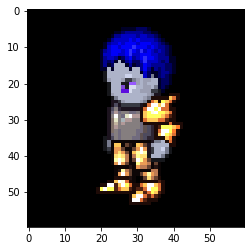

In [0]:
img=x_train[random.randint(0,x_train.shape[0]-1),:,:,:]
img=np.moveaxis(img,0,-1)
img=img.astype('float')
plt.imshow(img)

In [0]:
val_path='./data/val_data.h5'
x_val,y_val=load_data(val_path)
x_val=np.moveaxis(x_val,0,-1)
x_val=x_val/255.0
x_val=np.moveaxis(x_val,-1,0)
print(x_val.shape,y_val.shape)
val_df=TensorDataset(torch.from_numpy(x_val).cuda(),torch.from_numpy(y_val).cuda())
sprites_dataset_val=SpritesDataset(val_df)
val_loader=cycle(DataLoader(sprites_dataset_val,batch_size=batch_size,shuffle=False,drop_last=True))

(12816, 3, 60, 60) (12816,)


In [0]:
class Encoder(nn.Module):
    def __init__(self,z_dim,s_dim):
        super(Encoder,self).__init__()

        #60x60
        self.conv1=nn.Conv2d(3,16,kernel_size=5,stride=2,padding=1)
        self.inst_norm1=nn.InstanceNorm2d(num_features=16,track_running_stats=True)
        #29x29

        #29x29
        self.conv2=nn.Conv2d(16,32,kernel_size=5,stride=2,padding=1)
        self.inst_norm2=nn.InstanceNorm2d(num_features=32,track_running_stats=True)
        #14x14

        #14x14
        self.conv3=nn.Conv2d(32,64,kernel_size=5,stride=2,padding=1)
        self.inst_norm3=nn.InstanceNorm2d(num_features=64,track_running_stats=True)
        #6x6

        #6x6
        self.conv4=nn.Conv2d(64,128,kernel_size=5,stride=2,padding=1)
        self.inst_norm4=nn.InstanceNorm2d(num_features=128,track_running_stats=True)
        #2x2

        self.z_mu=nn.Linear(512,z_dim)
        self.z_logvar=nn.Linear(512,z_dim)

        self.s=nn.Linear(512,s_dim)
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.inst_norm1(x)
        x=F.relu(x)

        x=self.conv2(x)
        x=self.inst_norm2(x)
        x=F.relu(x)

        x=self.conv3(x)
        x=self.inst_norm3(x)
        x=F.relu(x)

        x=self.conv4(x)
        x=self.inst_norm4(x)
        x=F.relu(x)

        x=x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))
        
        mu_out=self.z_mu(x)
        logvar_out=self.z_logvar(x)
        s_out=self.s(x)

        return mu_out,logvar_out,s_out

class Decoder(nn.Module):
    def __init__(self,z_dim,s_dim):
        super(Decoder,self).__init__()

        self.z_input=nn.Linear(z_dim,512)

        self.s_input=nn.Linear(s_dim,512)

        self.deconv1=nn.ConvTranspose2d(256,64,kernel_size=4,stride=2,padding=0)
        self.inst_norm1=nn.InstanceNorm2d(num_features=64,track_running_stats=True)
        
        self.deconv2=nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=0)
        self.inst_norm2=nn.InstanceNorm2d(num_features=32,track_running_stats=True)

        self.deconv3=nn.ConvTranspose2d(32,16,kernel_size=4,stride=2,padding=0)
        self.inst_norm3=nn.InstanceNorm2d(num_features=16,track_running_stats=True)

        self.deconv4=nn.ConvTranspose2d(16,3,kernel_size=4,stride=2,padding=1)

        self.sigmoid=nn.Sigmoid()
    
    def forward(self,z,s):
        z=self.z_input(z)
        z=F.leaky_relu_(input=z,negative_slope=0.2)

        s=self.s_input(s)
        s=F.leaky_relu_(input=s,negative_slope=0.2)

        x=torch.cat((z,s),dim=1)
        x=x.view(x.size(0),256,2,2)

        x=self.deconv1(x)
        x=self.inst_norm1(x)
        x=F.leaky_relu(input=x,negative_slope=0.2,inplace=True)

        x=self.deconv2(x)
        x=self.inst_norm2(x)
        x=F.leaky_relu(input=x,negative_slope=0.2,inplace=True)

        x=self.deconv3(x)
        x=self.inst_norm3(x)
        x=F.leaky_relu(input=x,negative_slope=0.2,inplace=True)

        x=self.deconv4(x)
        x=self.sigmoid(x)

        return x

class ZSPredictor(nn.Module):
    def __init__(self,z_dim,s_dim):
        super(ZSPredictor,self).__init__()

        self.fc1=nn.Linear(z_dim,512)
        self.batch_norm1=nn.BatchNorm1d(num_features=512)

        self.fc2=nn.Linear(512,512)
        self.batch_norm2=nn.BatchNorm1d(num_features=512)
        
        self.fc3=nn.Linear(512,s_dim)
    
    def forward(self,z):
        z=self.fc1(z)
        z=self.batch_norm1(z)
        z=F.relu(z)

        z=self.fc2(z)
        z=self.batch_norm2(z)
        z=F.relu(z)

        z=self.fc3(z)
        return z

class SZPredictor(nn.Module):
    def __init__(self,z_dim,s_dim):
        super(SZPredictor,self).__init__()

        self.fc1=nn.Linear(s_dim,512)
        self.batch_norm1=nn.BatchNorm1d(num_features=512)

        self.fc2=nn.Linear(512,512)
        self.batch_norm2=nn.BatchNorm1d(num_features=512)
        
        self.fc3=nn.Linear(512,z_dim)
    
    def forward(self,z):
        z=self.fc1(z)
        z=self.batch_norm1(z)
        z=F.relu(z)

        z=self.fc2(z)
        z=self.batch_norm2(z)
        z=F.relu(z)

        z=self.fc3(z)
        return z

class Classifier(nn.Module):
    def __init__(self,dim,n_classes):
        super(Classifier,self).__init__()
        
        self.fc1=nn.Linear(dim,512)
        self.batch_norm1=nn.BatchNorm1d(512)

        self.fc2=nn.Linear(512,512)
        self.batch_norm2=nn.BatchNorm1d(512)
        self.leaky_relu=nn.LeakyReLU(negative_slope=0.2,inplace=True)

        self.fc3=nn.Linear(512,n_classes)
    
    def forward(self,x):
        x=self.fc1(x)
        x=self.batch_norm1(x)
        x=self.fc2(x)
        x=self.batch_norm2(x)
        x=self.leaky_relu(x)
        x=self.fc3(x)
        x=F.softmax(x,dim=1)
        return x

In [0]:
z_dim=512
s_dim=64
learning_rate=0.0001
n_classes=672
epochs=100
kl_div_coef=3
reconstruction_coef=2
reverse_cycle_coef=10
img_size=60
n_channels=3

In [0]:
n_batches_train=len(sprites_dataset_train)//batch_size
n_batches_val=len(sprites_dataset_val)//batch_size

In [0]:
encoder=Encoder(z_dim,s_dim)
decoder=Decoder(z_dim,s_dim)

encoder=encoder.to(device)
decoder=decoder.to(device)

forward_optimiser=torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)
reverse_optimiser=torch.optim.Adam(encoder.parameters(),lr=learning_rate)

forward_optim_scheduler=torch.optim.lr_scheduler.StepLR(forward_optimiser,step_size=80,gamma=0.1)
reverse_optim_scheduler=torch.optim.lr_scheduler.StepLR(reverse_optimiser,step_size=80,gamma=0.1)

print(encoder)
total_params=sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print('total_params:',total_params)
print()
print(decoder)
total_params=sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print('total_params:',total_params)

Encoder(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (inst_norm1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (inst_norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (inst_norm3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (inst_norm4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (z_mu): Linear(in_features=512, out_features=512, bias=True)
  (z_logvar): Linear(in_features=512, out_features=512, bias=True)
  (s): Linear(in_features=512, out_features=64, bias=True)
)
total_params: 828384

Decoder(
  (z_input): Linear(in_features=512, out_features=512, bias=

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.

Epoch:95
Step:20
reconstruction_loss:0.011310826987028122
kl_divergence_loss:0.0027641914784908295
reverse_cycle_loss:7.749301403237041e-06

Epoch:95
Step:30
reconstruction_loss:0.009809951297938824
kl_divergence_loss:0.0025191716849803925
reverse_cycle_loss:2.9232910492282826e-06

Epoch:95
Step:40
reconstruction_loss:0.008625945076346397
kl_divergence_loss:0.0025432920083403587
reverse_cycle_loss:2.691932650122908e-06

Epoch:95
Step:50
reconstruction_loss:0.00957736186683178
kl_divergence_loss:0.002635159995406866
reverse_cycle_loss:7.871840352891013e-06

Epoch:95
Step:60
reconstruction_loss:0.009274369105696678
kl_divergence_loss:0.0025884946808218956
reverse_cycle_loss:1.6447245798190124e-05

Epoch:95
Step:70
reconstruction_loss:0.01082189567387104
kl_divergence_loss:0.0026355485897511244
reverse_cycle_loss:6.4185123846982606e-06

Epoch:95
Step:80
reconstruction_loss:0.009863409213721752
kl_divergence_loss:0.0025567736010998487
rev

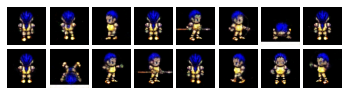

In [0]:
reconstruction_loss_list,kl_div_loss_list,reverse_cycle_loss_list=[],[],[]
x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
x2=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
x3=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
z_latent_space=torch.FloatTensor(batch_size,z_dim).to(device)

start_time=time.time()
for epoch in range(epochs):
    forward_optim_scheduler.step()
    reverse_optim_scheduler.step()
    loss1=0
    loss2=0
    loss3=0

    for i in range(n_batches_train):
        #forward cycle
        forward_optimiser.zero_grad()
        
        img1_batch,img2_batch,_=next(train_loader)
        x1.copy_(img1_batch)
        x2.copy_(img2_batch)

        z1_mu,z1_logvar,s1=encoder(x1)
        z2_mu,z2_logvar,s2=encoder(x2)

        z1_latent_space=reparameterize(mu=z1_mu,logvar=z1_logvar,is_train=True)
        z2_latent_space=reparameterize(mu=z2_mu,logvar=z2_logvar,is_train=True)

        reconstructed_x1=decoder(z1_latent_space,s2)
        reconstructed_x2=decoder(z2_latent_space,s1)

        kl_div1=(kl_div_coef*(-0.5*torch.sum(1+z1_logvar-z1_mu.pow(2)-z1_logvar.exp())))/(batch_size*n_channels*img_size*img_size)
        kl_div2=(kl_div_coef*(-0.5*torch.sum(1+z2_logvar-z2_mu.pow(2)-z2_logvar.exp())))/(batch_size*n_channels*img_size*img_size)
        
        reconstruction_err1=reconstruction_coef*l2_loss(reconstructed_x1,Variable(x1))
        reconstruction_err2=reconstruction_coef*l2_loss(reconstructed_x2,Variable(x2))

        kl_div1.backward(retain_graph=True)
        kl_div2.backward(retain_graph=True)
        reconstruction_err1.backward(retain_graph=True)
        reconstruction_err2.backward(retain_graph=True)

        reconstruction_err=(reconstruction_err1+reconstruction_err2)/reconstruction_coef
        kl_div_err=(kl_div1+kl_div2)/kl_div_coef

        forward_optimiser.step()

        #reverse cycle
        reverse_optimiser.zero_grad()

        img1_batch,_,_=next(train_loader)
        img2_batch,_,_=next(train_loader)

        x1.copy_(img1_batch)
        x2.copy_(img2_batch)

        _,_,s1=encoder(Variable(x1))
        _,_,s2=encoder(Variable(x2))

        z_latent_space.normal_(0.,1.)

        reconstructed_x1_1=decoder(z_latent_space,s1)
        reconstructed_x2_1=decoder(z_latent_space,s2)

        z1_mu,z1_logvar,_=encoder(reconstructed_x1_1)
        z2_mu,z2_logvar,_=encoder(reconstructed_x2_1)

        z1_latent_space=reparameterize(mu=z1_mu,logvar=z1_logvar,is_train=False)
        z2_latent_space=reparameterize(mu=z2_mu,logvar=z2_logvar,is_train=False)

        reverse_cycle_loss=reverse_cycle_coef*l1_loss(z1_latent_space,z2_latent_space)
        reverse_cycle_loss.backward()
        reverse_cycle_loss/=reverse_cycle_coef
        
        reverse_optimiser.step()

        loss1+=reconstruction_err.data.storage().tolist()[0]
        loss2+=kl_div_err.data.storage().tolist()[0]
        loss3+=reverse_cycle_loss.data.storage().tolist()[0]

        if (i+1)%10==0:
            print('Epoch:'+str(epoch+1))
            print('Step:'+str(i+1))
            print('reconstruction_loss:'+str(reconstruction_err.data.storage().tolist()[0]))
            print('kl_divergence_loss:'+str(kl_div_err.data.storage().tolist()[0]))
            print('reverse_cycle_loss:'+str(reverse_cycle_loss.data.storage().tolist()[0]))
            print()

    reconstruction_loss_list.append(loss1/n_batches_train)
    kl_div_loss_list.append(loss2/n_batches_train)
    reverse_cycle_loss_list.append(loss3/n_batches_train)
    
    if (epoch+1)%5==0 or (epoch+1==epochs):
        torch.save(encoder.state_dict(),os.getcwd()+'/checkpoints/encoder_weights/encoder.pt')
        torch.save(decoder.state_dict(),os.getcwd()+'/checkpoints/decoder_weights/decoder.pt')

        #train
        img1_batch,img2_batch,_=next(train_loader)
        img3_batch,_,_=next(train_loader)

        x1.copy_(img1_batch)
        x2.copy_(img2_batch)
        x3.copy_(img3_batch)

        z1_mu,z1_logvar,_=encoder(Variable(x1))
        _,_,s2=encoder(Variable(x2))
        z3_mu,z3_logvar,_=encoder(Variable(x3))

        z1_latent_space=reparameterize(mu=z1_mu,logvar=z1_logvar,is_train=False)
        z3_latent_space=reparameterize(mu=z3_mu,logvar=z3_logvar,is_train=False)

        reconstructed_x1_1=decoder(z1_latent_space,s2)
        reconstructed_x3_1=decoder(z3_latent_space,s2)

        img_batch=np.transpose(x1.cpu().numpy(),(0,2,3,1))
        plot_grid(img_batch,name=str(epoch+1),df='train',save=True)

        reconstructed_x=np.transpose(reconstructed_x1_1.cpu().data.numpy(),(0,2,3,1))
        plot_grid(reconstructed_x,name=str(epoch+1)+'_pred',df='train',save=True)

        z_batch=np.transpose(x3.cpu().numpy(),(0,2,3,1))
        plot_grid(z_batch,name=str(epoch+1)+'_z',df='train',save=True)

        reconstructed_z=np.transpose(reconstructed_x3_1.cpu().data.numpy(),(0,2,3,1))
        plot_grid(reconstructed_z,df='train',name=str(epoch+1)+'_pred_z',save=True)

        #val
        img1_batch,img2_batch,_=next(val_loader)
        img3_batch,_,_=next(val_loader)

        x1.copy_(img1_batch)
        x2.copy_(img2_batch)
        x3.copy_(img3_batch)

        z1_mu,z1_logvar,_=encoder(Variable(x1))
        _,_,s2=encoder(Variable(x2))
        z3_mu,z3_logvar,_=encoder(Variable(x3))

        z1_latent_space=reparameterize(mu=z1_mu,logvar=z1_logvar,is_train=False)
        z3_latent_space=reparameterize(mu=z3_mu,logvar=z3_logvar,is_train=False)

        reconstructed_x1_1=decoder(z1_latent_space,s2)
        reconstructed_x3_1=decoder(z3_latent_space,s2)

        img_batch=np.transpose(x1.cpu().numpy(),(0,2,3,1))
        plot_grid(img_batch,name=str(epoch+1),df='val',save=True)

        reconstructed_x=np.transpose(reconstructed_x1_1.cpu().data.numpy(),(0,2,3,1))
        plot_grid(reconstructed_x,name=str(epoch+1)+'_pred',df='val',save=True)

        z_batch=np.transpose(x3.cpu().numpy(),(0,2,3,1))
        plot_grid(z_batch,name=str(epoch+1)+'_z',df='val',save=True)

        reconstructed_z=np.transpose(reconstructed_x3_1.cpu().data.numpy(),(0,2,3,1))
        plot_grid(reconstructed_z,df='val',name=str(epoch+1)+'_pred_z',save=True)

In [0]:
print('total_time:'+str(time.time()-start_time))

total_time:19045.484961271286


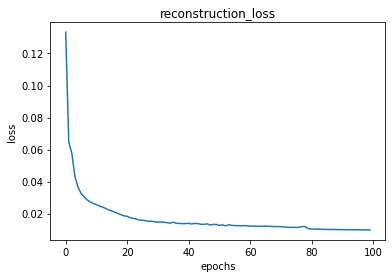

In [0]:
plt.figure()
plt.title('reconstruction_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(reconstruction_loss_list)

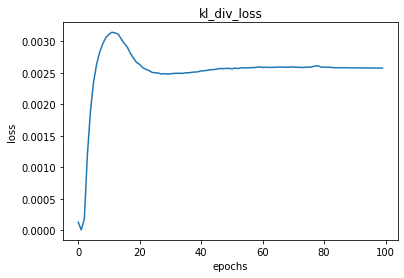

In [0]:
plt.figure()
plt.title('kl_div_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(kl_div_loss_list)

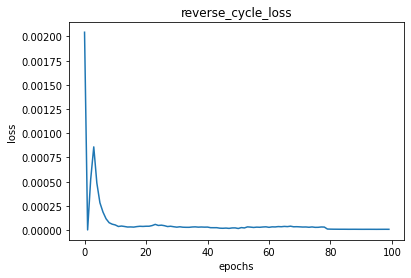

In [0]:
plt.figure()
plt.title('reverse_cycle_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(reverse_cycle_loss_list)

In [0]:
with h5py.File('metrics_list.h5','w') as out:
    out.create_dataset("reconstruction",data=np.array(reconstruction_loss_list))
    out.create_dataset("kl_div",data=np.array(kl_div_loss_list))
    out.create_dataset("reverse",data=np.array(reverse_cycle_loss_list))

In [0]:
train_loader=DataLoader(train_df,shuffle=True,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_df,batch_size=batch_size,shuffle=True,drop_last=True)
epochs=20
z_s_predictor=ZSPredictor(z_dim,s_dim)
z_s_predictor=z_s_predictor.to(device)

encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))
criterion=nn.MSELoss()
optim=torch.optim.Adam(z_s_predictor.parameters())
print(z_s_predictor)
total_params=sum(p.numel() for p in z_s_predictor.parameters() if p.requires_grad)
print('total_params:'+str(total_params))

ZSPredictor(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
)
total_params:560192


In [0]:
loss_list=[]
val_loss_list=[]
x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
for epoch in range(20):
    train_iterator=iter(train_loader)
    val_iterator=iter(val_loader)
    epoch_loss=0
    z_s_predictor.train()
    for i,batch in enumerate(train_iterator):
        optim.zero_grad()
        x=batch[0]
        x1.copy_(x)
        with torch.no_grad():
            z_mu,z_logvar,s=encoder(Variable(x1))
        s_pred=z_s_predictor(z_mu)
        loss=criterion(s_pred,s)
        epoch_loss+=loss.item()
        loss.backward()
        optim.step()

    z_s_predictor.eval()
    val_loss=0
    with torch.no_grad():
        for i,batch in enumerate(val_iterator):
            x=batch[0]
            x1.copy_(x)
            z_mu,z_logvar,s=encoder(Variable(x1))
            s_pred=z_s_predictor(z_mu)
            loss=criterion(s_pred,s)
            val_loss+=loss.item()

    print('Epoch: '+str(epoch+1)+'/'+str(epochs)+' loss:'+str(epoch_loss/n_batches_train)+' val_loss:'+str(val_loss/n_batches_val))
    loss_list.append(epoch_loss/n_batches_train)
    val_loss_list.append(val_loss/n_batches_val)
torch.save(z_s_predictor.state_dict(),os.getcwd()+'/checkpoints/z_s_predictor.pt')

Epoch: 1/20 loss:3.239441724550381 val_loss:0.08653507050126791
Epoch: 2/20 loss:0.0872758794468727 val_loss:0.0982483983784914
Epoch: 3/20 loss:0.05987163442019507 val_loss:0.047698825616389516
Epoch: 4/20 loss:0.048774057930911614 val_loss:0.039599313512444494
Epoch: 5/20 loss:0.04117373905727546 val_loss:0.02644416520372033
Epoch: 6/20 loss:0.03579979896840217 val_loss:0.02194177015684545
Epoch: 7/20 loss:0.03303536407971125 val_loss:0.019991402169689535
Epoch: 8/20 loss:0.029100401804065534 val_loss:0.01774837837088853
Epoch: 9/20 loss:0.02668088150525586 val_loss:0.01571772416587919
Epoch: 10/20 loss:0.024311212927317447 val_loss:0.016334851407445967
Epoch: 11/20 loss:0.022818121273177776 val_loss:0.017729174308478833
Epoch: 12/20 loss:0.02133910985489329 val_loss:0.01566225812304765
Epoch: 13/20 loss:0.019922444675278535 val_loss:0.02005890098400414
Epoch: 14/20 loss:0.018900496437609625 val_loss:0.020178315127268434
Epoch: 15/20 loss:0.018474365403647903 val_loss:0.0175484630977

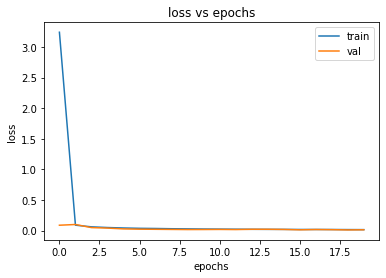

In [0]:
plt.figure()
plt.title('loss vs epochs')
plt.plot(loss_list,label='train')
plt.plot(val_loss_list,label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [0]:
train_loader=DataLoader(train_df,shuffle=True,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_df,batch_size=batch_size,shuffle=True,drop_last=True)
s_z_predictor=SZPredictor(z_dim,s_dim)
s_z_predictor=s_z_predictor.to(device)

encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))
criterion=nn.MSELoss()
optim=torch.optim.Adam(s_z_predictor.parameters())
print(s_z_predictor)
total_params=sum(p.numel() for p in s_z_predictor.parameters() if p.requires_grad)
print('total_params:'+str(total_params))
epochs=20

SZPredictor(
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
)
total_params:560640


In [0]:
loss_list=[]
val_loss_list=[]
x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
for epoch in range(epochs):
    train_iterator=iter(train_loader)
    val_iterator=iter(val_loader)
    epoch_loss=0
    s_z_predictor.train()
    for i,batch in enumerate(train_iterator):
        optim.zero_grad()
        x=batch[0]
        x1.copy_(x)
        with torch.no_grad():
            z_mu,z_logvar,s=encoder(Variable(x1))
        z_pred=s_z_predictor(s)
        loss=criterion(z_pred,z_mu)
        epoch_loss+=loss.item()
        loss.backward()
        optim.step()

    s_z_predictor.eval()
    val_loss=0
    for i,batch in enumerate(val_iterator):
        x=batch[0]
        x1.copy_(x)
        z_mu,z_logvar,s=encoder(Variable(x1))
        z_pred=s_z_predictor(s)
        loss=criterion(z_pred,z_mu)
        val_loss+=loss.item()

    print('Epoch: '+str(epoch+1)+'/'+str(epochs)+' loss:'+str(epoch_loss/n_batches_train)+' val_loss:'+str(val_loss/n_batches_val))
    loss_list.append(epoch_loss/n_batches_train)
    val_loss_list.append(val_loss/n_batches_val)

Epoch: 1/20 loss:0.007774241978852011 val_loss:0.4045584946870804
Epoch: 2/20 loss:0.00381184563027333 val_loss:0.08273964572697878
Epoch: 3/20 loss:0.0029213260033456004 val_loss:0.1836928567290306
Epoch: 4/20 loss:0.002402840354128091 val_loss:0.10241656798869371
Epoch: 5/20 loss:0.002060957020232387 val_loss:0.03813016274943948
Epoch: 6/20 loss:0.0018300081711269164 val_loss:0.01902663266286254
Epoch: 7/20 loss:0.0016524385189362835 val_loss:0.09714765671640635
Epoch: 8/20 loss:0.0015045221048246452 val_loss:0.06490940112620593
Epoch: 9/20 loss:0.0013735989773672797 val_loss:0.034824853502213954
Epoch: 10/20 loss:0.00125332774980523 val_loss:0.028217969369143246
Epoch: 11/20 loss:0.0011298183195976366 val_loss:0.058229678571224214
Epoch: 12/20 loss:0.0010305292822718754 val_loss:0.05552407797425985
Epoch: 13/20 loss:0.0009362172935888332 val_loss:0.051724748499691484
Epoch: 14/20 loss:0.0008695424369807697 val_loss:0.022902265843003988
Epoch: 15/20 loss:0.0008178957104816926 val_los

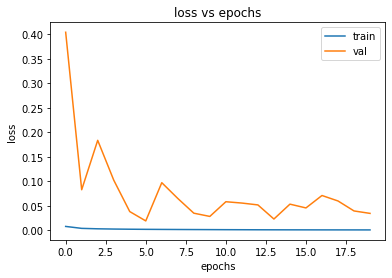

In [0]:
plt.figure()
plt.title('loss vs epochs')
plt.plot(loss_list,label='train')
plt.plot(val_loss_list,label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

In [0]:
s_classifier=Classifier(s_dim,n_classes)
s_classifier=s_classifier.to(device)
criterion=nn.BCELoss()
optimiser=torch.optim.Adam(s_classifier.parameters())
print(s_classifier)
total_params=sum(p.numel() for p in s_classifier.parameters() if p.requires_grad)
print('total_params:'+str(total_params))

encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))

train_loader=DataLoader(train_df,shuffle=True,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_df,batch_size=batch_size,shuffle=True,drop_last=True)
epochs=20

Classifier(
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc3): Linear(in_features=512, out_features=672, bias=True)
)
total_params:642720


In [0]:
def train(model,iterator,optimiser,criterion):
  epoch_loss=0
  epoch_accuracy=0
  model.train()
  x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
  for i,batch in enumerate(iterator):
    x=batch[0]
    x1.copy_(x)
    y=batch[1]
    with torch.no_grad():
        z_mu,z_logvar,s=encoder(Variable(x1))
    optimiser.zero_grad()
    pred=model(s)
    y=y.cpu().detach().numpy()
    y=np.eye(n_classes)[y]
    y=torch.from_numpy(y).float().cuda()
    loss=criterion(pred,y)
    acc=accuracy(pred,y)
    loss.backward()
    optimiser.step()
    epoch_loss+=loss.item()
    epoch_accuracy+=acc
  return epoch_loss/len(iterator),epoch_accuracy/len(iterator)

def evaluate(model,iterator,criterion):
  model.eval()
  epoch_loss=0
  epoch_accuracy=0
  with torch.no_grad():
    x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
    for i,batch in enumerate(iterator):
      x=batch[0]
      x1.copy_(x)
      y=batch[1]
      z_mu,z_logvar,s=encoder(Variable(x1))
      pred=model(s)
      y=y.cpu().detach().numpy()
      y=np.eye(n_classes)[y]
      y=torch.from_numpy(y).float().cuda()
      loss=criterion(pred,y)
      acc=accuracy(pred,y)
      epoch_loss+=loss.item()
      epoch_accuracy+=acc
  return epoch_loss/len(iterator),epoch_accuracy/len(iterator)

def accuracy(pred,y):
  count=0
  for i in range(len(pred)):
    idx=torch.argmax(pred[i])
    idx_class=torch.argmax(y[i])
    if idx.item()==idx_class.item():
      count+=1
  return count/len(y)

train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
for epoch in range(epochs):
  train_iterator=iter(train_loader)
  val_iterator=iter(val_loader)
  train_loss,train_acc=train(s_classifier,train_iterator,optimiser,criterion)
  val_loss,val_acc=evaluate(s_classifier,val_iterator,criterion)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  print('Epoch ',epoch+1,'/',epochs,' loss:',train_loss,' acc:',train_acc,' val_loss:',val_loss,' val_acc:',val_acc)

Epoch  1 / 20  loss: 0.0033425089968502414  acc: 0.5001461330935252  val_loss: 0.06073162972927094  val_acc: 0.0
Epoch  2 / 20  loss: 0.0024877060325347263  acc: 0.5726618705035971  val_loss: 0.04970953091979027  val_acc: 0.0
Epoch  3 / 20  loss: 0.0023520788037981973  acc: 0.5883430755395683  val_loss: 0.074419100061059  val_acc: 0.0
Epoch  4 / 20  loss: 0.0022693954210514003  acc: 0.5976169064748201  val_loss: 0.039164524488151074  val_acc: 0.0
Epoch  5 / 20  loss: 0.002213534089341331  acc: 0.6056654676258992  val_loss: 0.03892936203628779  val_acc: 0.0
Epoch  6 / 20  loss: 0.0021688632968571977  acc: 0.6126686151079137  val_loss: 0.06787896078079939  val_acc: 0.0
Epoch  7 / 20  loss: 0.002124560187091689  acc: 0.6183003597122302  val_loss: 0.05755345512181521  val_acc: 0.0
Epoch  8 / 20  loss: 0.0020995304396329113  acc: 0.620402428057554  val_loss: 0.03885246293619275  val_acc: 0.0
Epoch  9 / 20  loss: 0.0020723536456499596  acc: 0.623111510791367  val_loss: 0.04567504193633795  v

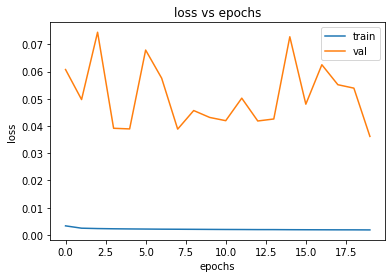

In [0]:
plt.figure()
plt.title('loss vs epochs')
plt.plot(train_loss_list,label='train')
plt.plot(val_loss_list,label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

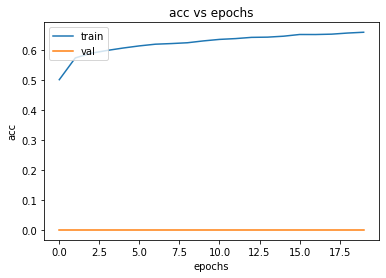

In [0]:
plt.figure()
plt.title('acc vs epochs')
plt.plot(train_acc_list,label='train')
plt.plot(val_acc_list,label='val')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='upper left')

In [0]:
z_classifier=Classifier(z_dim,n_classes)
z_classifier=z_classifier.to(device)
criterion=nn.BCELoss()
optimiser=torch.optim.Adam(z_classifier.parameters())
print(z_classifier)
total_params=sum(p.numel() for p in z_classifier.parameters() if p.requires_grad)
print('total_params:'+str(total_params))

encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))

train_loader=DataLoader(train_df,shuffle=True,batch_size=batch_size,drop_last=True)
val_loader=DataLoader(val_df,batch_size=batch_size,shuffle=True,drop_last=True)
epochs=20

Classifier(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc3): Linear(in_features=512, out_features=672, bias=True)
)
total_params:872096


In [0]:
def train(model,iterator,optimiser,criterion):
  epoch_loss=0
  epoch_accuracy=0
  model.train()
  x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
  for i,batch in enumerate(iterator):
    x=batch[0]
    x1.copy_(x)
    y=batch[1]
    z_mu,z_logvar,s=encoder(Variable(x1))
    z_latent_space=reparameterize(z_mu,z_logvar,is_train=True)
    optimiser.zero_grad()
    pred=model(z_latent_space)
    y=y.cpu().detach().numpy()
    y=np.eye(n_classes)[y]
    y=torch.from_numpy(y).float().cuda()
    loss=criterion(pred,y)
    acc=accuracy(pred,y)
    loss.backward()
    optimiser.step()
    epoch_loss+=loss.item()
    epoch_accuracy+=acc
  return epoch_loss/len(iterator),epoch_accuracy/len(iterator)

def evaluate(model,iterator,criterion):
  model.eval()
  epoch_loss=0
  epoch_accuracy=0
  with torch.no_grad():
    x1=torch.FloatTensor(batch_size,n_channels,img_size,img_size).to(device)
    for i,batch in enumerate(iterator):
      x=batch[0]
      x1.copy_(x)
      y=batch[1]
      z_mu,z_logvar,s=encoder(Variable(x1))
      pred=model(z_mu)
      y=y.cpu().detach().numpy()
      y=np.eye(n_classes)[y]
      y=torch.from_numpy(y).float().cuda()
      loss=criterion(pred,y)
      acc=accuracy(pred,y)
      epoch_loss+=loss.item()
      epoch_accuracy+=acc
  return epoch_loss/len(iterator),epoch_accuracy/len(iterator)

def accuracy(pred,y):
  count=0
  for i in range(len(pred)):
    idx=torch.argmax(pred[i])
    idx_class=torch.argmax(y[i])
    if idx.item()==idx_class.item():
      count+=1
  return count/len(y)

train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
for epoch in range(epochs):
  train_iterator=iter(train_loader)
  val_iterator=iter(val_loader)
  train_loss,train_acc=train(z_classifier,train_iterator,optimiser,criterion)
  val_loss,val_acc=evaluate(z_classifier,val_iterator,criterion)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  print('Epoch ',epoch+1,'/',epochs,' loss:',train_loss,' acc:',train_acc,' val_loss:',val_loss,' val_acc:',val_acc)

Epoch  1 / 20  loss: 0.0106331363045644  acc: 0.004192895683453237  val_loss: 0.014299641498364508  val_acc: 0.000703125
Epoch  2 / 20  loss: 0.010262277663397275  acc: 0.005294514388489209  val_loss: 0.01688443505205214  val_acc: 0.0
Epoch  3 / 20  loss: 0.010091523815402023  acc: 0.006272482014388489  val_loss: 0.018836292298510672  val_acc: 0.0
Epoch  4 / 20  loss: 0.009977788857365255  acc: 0.006722122302158274  val_loss: 0.02106296768411994  val_acc: 0.0
Epoch  5 / 20  loss: 0.009891355246734276  acc: 0.007003147482014389  val_loss: 0.022144274963065983  val_acc: 0.0
Epoch  6 / 20  loss: 0.009810736716436825  acc: 0.007700089928057554  val_loss: 0.02285810815170407  val_acc: 0.0
Epoch  7 / 20  loss: 0.009742454528513786  acc: 0.008003597122302157  val_loss: 0.023810953292995693  val_acc: 0.0
Epoch  8 / 20  loss: 0.009695727483322508  acc: 0.008183453237410073  val_loss: 0.023992545595392586  val_acc: 0.0
Epoch  9 / 20  loss: 0.0096542175658208  acc: 0.008498201438848921  val_loss:

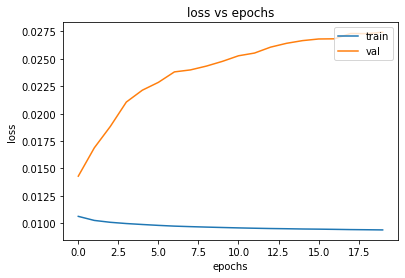

In [0]:
plt.figure()
plt.title('loss vs epochs')
plt.plot(train_loss_list,label='train')
plt.plot(val_loss_list,label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

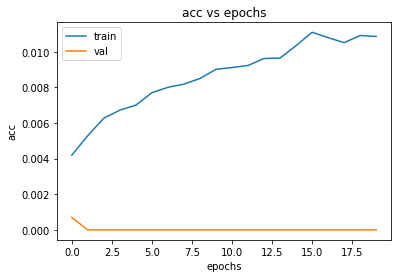

In [0]:
plt.figure()
plt.title('acc vs epochs')
plt.plot(train_acc_list,label='train')
plt.plot(val_acc_list,label='val')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(loc='upper left')

In [0]:
test_path='./data/test_data.h5'
x_test,y_test=load_data(test_path)
x_test=np.moveaxis(x_test,0,-1)
x_test=x_test/255.0
x_test=np.moveaxis(x_test,-1,0)
print(x_test.shape,y_test.shape)
test_df=TensorDataset(torch.from_numpy(x_test).to(device),torch.from_numpy(y_test).to(device))

(17800, 3, 60, 60) (17800,)


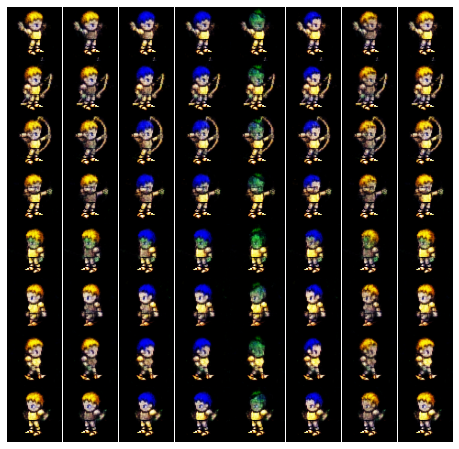

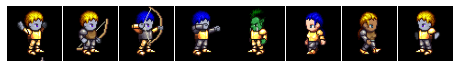

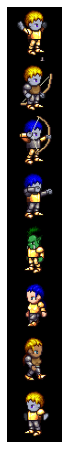

In [0]:
import matplotlib.gridspec as gridspec
col=[]
row=[]
for i in range(8):
    img,_=test_df[random.randint(0,len(test_df)-1)]
    row.append(img)
    col.append(img)

encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
decoder=Decoder(z_dim,s_dim)
decoder=decoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))
decoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/decoder_weights/decoder.pt'))

gs1=gridspec.GridSpec(8,8,width_ratios=[1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))
x1=torch.FloatTensor(1,n_channels,img_size,img_size).to(device)
x2=torch.FloatTensor(1,n_channels,img_size,img_size).to(device)
for i in range(len(row)):
    for j in range(len(col)):
        x1.copy_(row[i])
        x2.copy_(col[j])
        z1_mu,z1_logvar,s1=encoder(Variable(x1))
        z2_mu,z2_logvar,s2=encoder(Variable(x2))
        reconstructed_img=decoder(z1_mu,s2)
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)

gs2=gridspec.GridSpec(1,8,width_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig2=plt.figure(figsize=(8,1))
for i in range(8):
    img=row[i]
    img=img.squeeze(0)
    img=np.transpose(img.cpu().data.numpy(),(1,2,0))
    img=img.astype('float')
    ax=plt.subplot(gs2[i])
    ax.axis('off')
    ax.imshow(img)

fig3=plt.figure(figsize=(1,8))
gs3=gridspec.GridSpec(8,1,height_ratios=[1,1,1,1,1,1,1,1],wspace=0,hspace=0)
for i in range(8):
    img=col[i]
    img=img.squeeze(0)
    img=np.transpose(img.cpu().data.numpy(),(1,2,0))
    img=img.astype('float')
    ax=plt.subplot(gs3[i])
    ax.axis('off')
    ax.imshow(img)

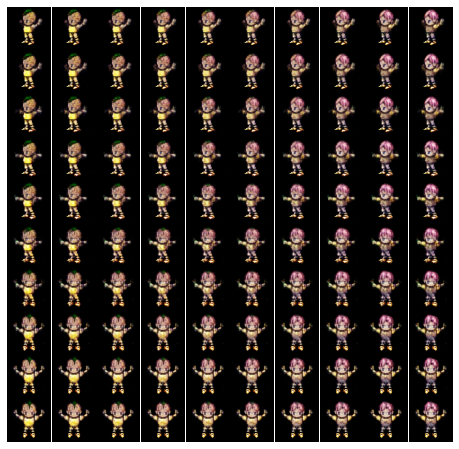

In [0]:
import matplotlib.gridspec as gridspec

img1,_=test_df[random.randint(0,len(test_df)-1)]
img2,_=test_df[random.randint(0,len(test_df)-1)]
encoder=Encoder(z_dim,s_dim)
encoder=encoder.to(device)
decoder=Decoder(z_dim,s_dim)
decoder=decoder.to(device)
encoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/encoder_weights/encoder.pt'))
decoder.load_state_dict(torch.load('/content/drive/My Drive/DL/assgn3/checkpoints/decoder_weights/decoder.pt'))

gs1=gridspec.GridSpec(10,10,width_ratios=[1,1,1,1,1,1,1,1,1,1],height_ratios=[1,1,1,1,1,1,1,1,1,1],wspace=0,hspace=0)
fig1=plt.figure(figsize=(8,8))
x1=torch.FloatTensor(1,n_channels,img_size,img_size).to(device)
x2=torch.FloatTensor(1,n_channels,img_size,img_size).to(device)
x1.copy_(img1)
x2.copy_(img2)

z1_mu,z1_logvar,s1=encoder(Variable(x1))
z2_mu,z2_logvar,s2=encoder(Variable(x2))
diff_z=z2_mu-z1_mu
diff_s=s2-s1
n=10
inter_z=torch.zeros((n,1,diff_z.shape[1])).to(device)
inter_s=torch.zeros((n,1,diff_s.shape[1])).to(device)
for i in range(n):
    inter_z[i]=z1_mu+(i/(n-1))*diff_z
    inter_s[i]=s1+(i/(n-1))*diff_s

for i in range(10):
    for j in range(10):
        reconstructed_img=decoder(inter_z[i],inter_s[j])
        reconstructed_img=reconstructed_img.squeeze(0)
        reconstructed_img=np.transpose(reconstructed_img.cpu().data.numpy(),(1,2,0))
        ax=plt.subplot(gs1[i,j])
        ax.axis('off')
        ax.imshow(reconstructed_img)